## Reference :

- https://www.kaggle.com/c/nyc-taxi-trip-duration/data

## Process :

    - 0 LOAD DATA 
    - 1 SIMPLE FEATURE EXTRACT
    - 2 DATA OVERVIEW
        -2.1 vendor_id
        -2.2 pickup_day & dropoff_day
        -2.3 passenger_count
        -2.4 pickup & dropoff locations (lon & lat )
        -2.5 store_and_fwd_flag
        -2.6 trip_duration
    - 3 FEATURE ENGINEERING 
    - 4 FEATURE ANALYSIS 
        -4.1 Duration VS. Distance
        -4.2 Driving Direction
        -4.3 Clustering 
        -4.4 Avg speed, orders on clustering 
        -4.5 Cyclic timestamp (week, hour, weekhour)
    - 5 DATA CLEANING ANALYSIS 



- File descriptions

>- train.csv - the training set (contains 1458644 trip records)
- test.csv - the testing set (contains 625134 trip records)
- sample_submission.csv - a sample submission file in the correct format
    
    
- Data fields

>- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds


In [1]:
# load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


## - 0) Load data

In [2]:
# load data

df_train = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/train.csv')
df_test = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/test.csv')
sampleSubmission = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/sample_submission.csv')

In [3]:
df_train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


## -1) Simple feature extract 

In [4]:
# help function


def basic_feature_extract(df):
    df_= df.copy()
    # pickup
    df_["pickup_date"] = pd.to_datetime(df_.pickup_datetime.apply(lambda x : x.split(" ")[0]))
    df_["pickup_hour"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["pickup_year"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["pickup_month"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["pickup_weekday"] = df_.pickup_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    # dropoff
    # in case test data dont have dropoff_datetime feature
    try:
        df_["dropoff_date"] = pd.to_datetime(df_.dropoff_datetime.apply(lambda x : x.split(" ")[0]))
        df_["dropoff_hour"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
        df_["dropoff_year"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
        df_["dropoff_month"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
        df_["dropoff_weekday"] = df_.dropoff_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    except:
        pass 
    return df_

# get weekday
import calendar

def get_weekday(df):
    list(calendar.day_name)
    df_=df.copy()
    df_['pickup_week_'] = pd.to_datetime(df_.pickup_datetime,coerce=True).dt.weekday
    df_['pickup_weekday_'] = df_['pickup_week_'].apply(lambda x: calendar.day_name[x])
    return df_

# get trip duration 
def get_duration(df):
    df_= df.copy()
    df_['trip_duration_cal'] = pd.to_datetime(df_['dropoff_datetime']) - pd.to_datetime(df_['pickup_datetime'])
    return df_
    



In [5]:
#pd.to_datetime(df_train.pickup_datetime,coerce=True).dt.weekday

In [6]:
# one may take few minutes 
df_train_ = basic_feature_extract(df_train)

In [7]:
df_train_ = get_duration(df_train_)
df_train_ = get_weekday(df_train_)

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:30: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead


In [8]:
#df_train_.head(2)
#df_train_[['pickup_datetime','dropoff_datetime','trip_duration']]

In [9]:
#df_train_[['dropoff_datetime','dropoff_date','dropoff_hour','dropoff_year','dropoff_month']]


## - 2) Data overview

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


- train data set has  1458644 trip records (every ride per record),
    `no missing values` 

In [11]:
df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_month,pickup_weekday,dropoff_date,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday,trip_duration_cal,pickup_week_,pickup_weekday_
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,03,0,2016-03-14,17,2016,03,0,00:07:35,0,Monday


### 2-1) vendor_id

In [12]:
df_train.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

Vendor_id means id of vendors, here we can see there are 2 vendors serve 
in this NYC taxi record, they have `similar` ride counts

### 2-2) pickup_day & dropoff_day 

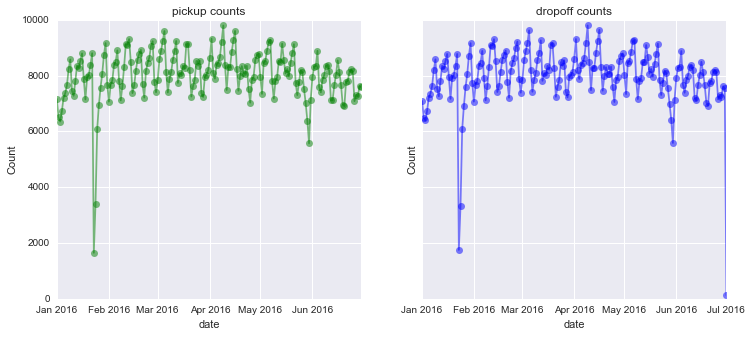

In [13]:
fig, ax = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(12, 5)

ax[0].plot(df_train_.groupby('pickup_date').count()['id'], 'go-', alpha=0.5)
ax[1].plot(df_train_.groupby('dropoff_date').count()['id'], 'bo-', alpha=0.5)

ax[0].set(xlabel='date', ylabel='Count',title="pickup counts")
ax[1].set(xlabel='date', ylabel='Count',title="dropoff counts")

plt.show()

- The orders countssudden fail in 2016-01-23, need to check deeper to see
  if this affect data quality 

- Averagely 7000 - 9000 counts of orders (pickup) per day.

### - 2-3) passenger_count

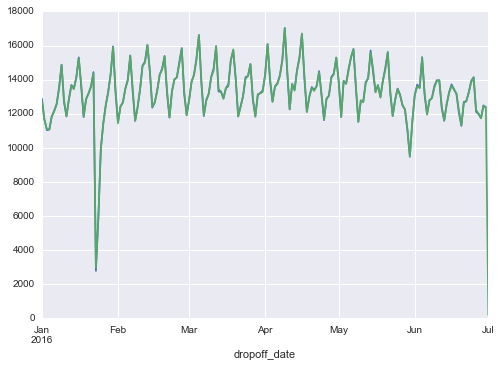

In [14]:
df_train_.groupby(['pickup_date']).sum()['passenger_count'].plot()
df_train_.groupby(['dropoff_date']).sum()['passenger_count'].plot()

In [15]:
df_train_.passenger_count.value_counts(sort=False)

0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: passenger_count, dtype: int64

- Averagely 12k - 16k passengers per day 
- Most taxi take 1 passengers per ride, but some numbers like 0,7,8,9 
  maybe are outliers 

### 2-4) pickup  & dropoff locations (lon & lat )

In [16]:
# ref 
# https://www.kaggle.com/misfyre/in-depth-nyc-taxi-eda-also-w-animation
# folloing ref above, here I drop outliers and do geo data visualization 
# (drop data point > 95% and < 5%)

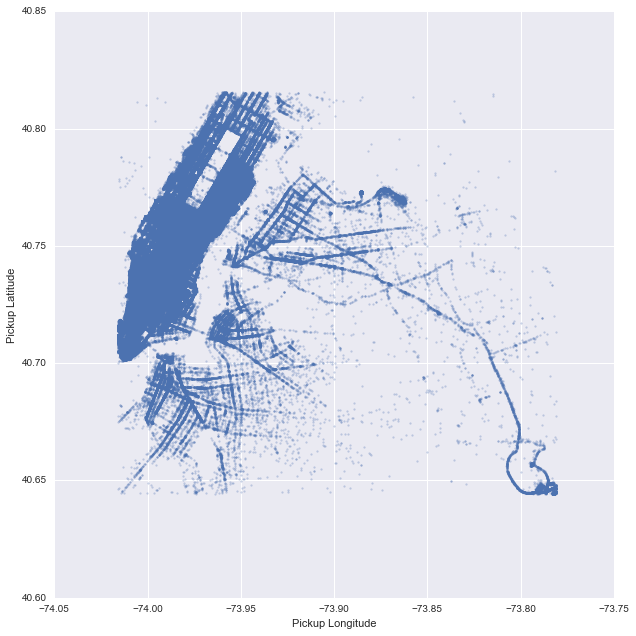

In [17]:
# pickup 
sns.lmplot(x="pickup_longitude", y="pickup_latitude", fit_reg=False, 
           size=9, scatter_kws={'alpha':0.3,'s':5}, data=df_train_[(
                 df_train_.pickup_longitude>df_train_.pickup_longitude.quantile(0.005))
               &(df_train_.pickup_longitude<df_train_.pickup_longitude.quantile(0.995))
               &(df_train_.pickup_latitude>df_train_.pickup_latitude.quantile(0.005))                           
               &(df_train_.pickup_latitude<df_train_.pickup_latitude.quantile(0.995))])

plt.xlabel('Pickup Longitude');
plt.ylabel('Pickup Latitude');
plt.show()

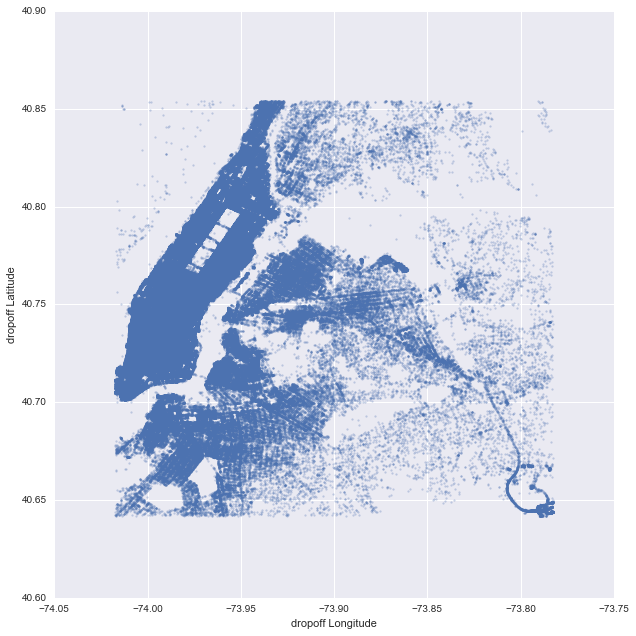

In [18]:
# dropoff 
sns.lmplot(x="dropoff_longitude", y="dropoff_latitude",fit_reg=False, 
           size=9, scatter_kws={'alpha':0.3,'s':5}, data=df_train_[(
                 df_train_.dropoff_longitude>df_train_.dropoff_longitude.quantile(0.005))
               &(df_train_.dropoff_longitude<df_train_.dropoff_longitude.quantile(0.995))
               &(df_train_.dropoff_latitude>df_train_.dropoff_latitude.quantile(0.005))                           
               &(df_train_.dropoff_latitude<df_train_.dropoff_latitude.quantile(0.995))])

plt.xlabel('dropoff Longitude');
plt.ylabel('dropoff Latitude');
plt.show()

##### We get an very interesting outcome from this visualization : 

1. Manhattan get `MOST` of pickup orders, since many people work there,
    it makes sense it's the place where main demands from 
    
2. Many dropoff orders `outside the  Manhattan area ` maybe because 
people work/srudy in Manhattan, but live in areas like Queens/Brooklyn..

3. JFK Airport (the point in east north) maybe be a `key point` affect 
duration, since many orders back and forth within the city and JFK,
it's a `not short` distance, may affect duration prediction alot.

### 2-5) store_and_fwd_flag	

In [19]:
df_train_.store_and_fwd_flag.value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

About  0.5% (8045/1450599) of orders (store_and_fwd_flag=Y) are not sent  immediately to vendor server, but hold in  the memory of taxi, need to investigate if this affact data quality as well 

### 2-6) trip_duration 

In [20]:
df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_month,pickup_weekday,dropoff_date,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday,trip_duration_cal,pickup_week_,pickup_weekday_
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,03,0,2016-03-14,17,2016,03,0,00:07:35,0,Monday


In [21]:
#df_train_.columns

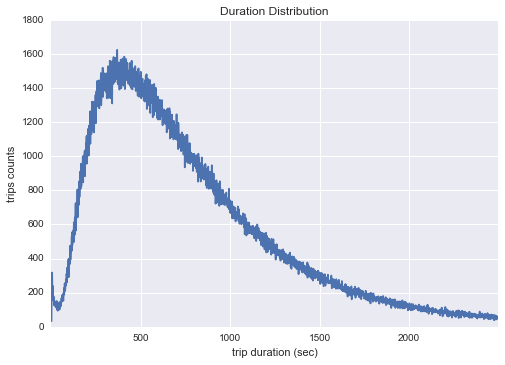

In [22]:
# trip duration overall distribution 
# remove outlier by only taking data under .97 quantile

tripduration = df_train_[df_train_.trip_duration < df_train_.trip_duration.quantile(.97)]
tripduration.groupby('trip_duration').count()['id'].plot()

plt.xlabel('trip duration (sec)')
plt.ylabel('trips counts')
plt.title('Duration Distribution')

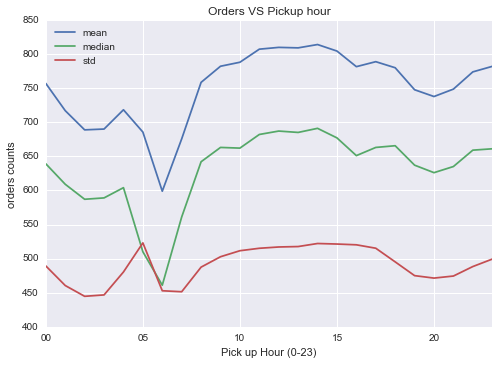

In [23]:
# pivot table
# http://pbpython.com/pandas-pivot-table-explained.html

#tripduration = df_train_[df_train_.trip_duration < df_train_.trip_duration.quantile(.97)]


pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc=np.mean)['trip_duration'].plot(label='mean')
pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc=np.median)['trip_duration'].plot(label='median')
pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc=np.std)['trip_duration'].plot(label='std')

plt.legend(loc=0)
plt.xlabel('Pick up Hour (0-23)')
plt.ylabel('orders counts ')
plt.title('Orders VS Pickup hour')
plt.show()

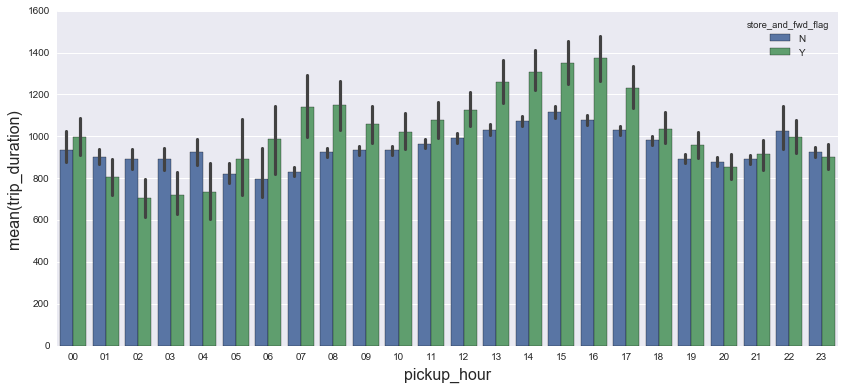

In [24]:
# plots trip duration on store_and_fwd_flag 
# (send back data to vendor server directly or save in taxi then upload because internet issues)

plt.figure(figsize=(14,6))
sns.barplot(x='pickup_hour',y='trip_duration',data=df_train_,hue='store_and_fwd_flag')
plt.xlabel('pickup_hour',fontsize=16)
plt.ylabel('mean(trip_duration)',fontsize=16)


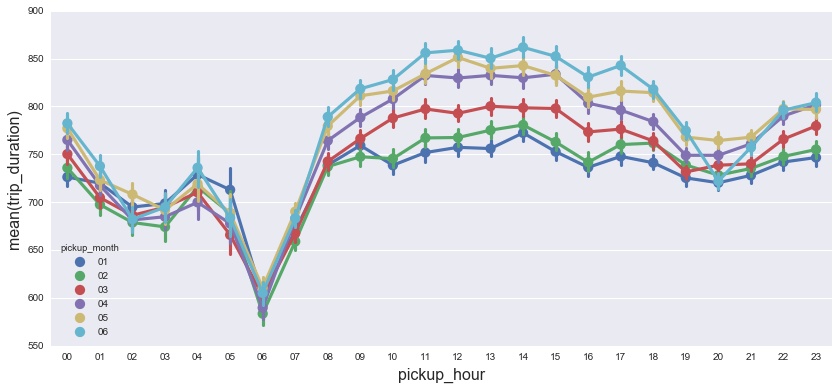

In [25]:
#  duration VS. pickup hour in given months 

plt.figure(figsize=(14,6))
sns.pointplot(x='pickup_hour',y='trip_duration',data=tripduration,hue='pickup_month')
plt.xlabel('pickup_hour',fontsize=16)
plt.ylabel('mean(trip_duration)',fontsize=16)

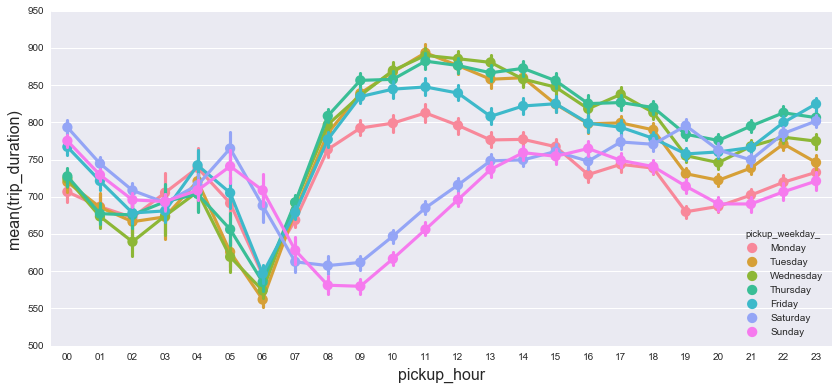

In [26]:
#  duration VS. pickup hour in weekdays 


plt.figure(figsize=(14,6))
sns.pointplot(x='pickup_hour',y='trip_duration',data=tripduration,hue='pickup_weekday_',hue_order=list(calendar.day_name))
plt.xlabel('pickup_hour',fontsize=16)
plt.ylabel('mean(trip_duration)',fontsize=16)

In [27]:
df_train_.groupby('trip_duration').count()['id'].tail(5)

# 86392 sec means 23 hours 
# 2049578 sec means 23 days 
# which are all no make sense 

trip_duration
86392      1
1939736    1
2049578    1
2227612    1
3526282    1
Name: id, dtype: int64

#### Duration is the prediction target in this competition :

1. Most trips finished within `6-10 minute` (400-600 sec)
2. Some trips take too long/too fast are obvious wrong, maybe because 
of tech/maunal operation issues, should filter them in following process

3. Duration are `longer ` when `store_and_fwd_flag = Y`, maybe because 
   internet is bad in areas off downtowm, imply taxi drivers `much longer`
   relatively.
   
4. Duration `RISE` dramtically from 7 AM to 10 AM, maybe owing to traffic 
jam and people start moving to NYC from nearyby areas when daytime

5. Months only affect duration `a little bit` ; while `pickup hours` seems may be infulence that more 

6. `Weekday` is apparently relative to duration. `Duration are high duing wokday (Mon.-Fri.)`, since people work, taxi are much more busy to take people from Manhattan <---> outside Manhattan


## 3) Feature engineering 

In [28]:
# feature extract

###  distance 
# https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-377?scriptVersionId=1369021

# Haversine distance
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # km
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  #  km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h 

# Manhattan distance
# Taxi cant fly ! have to move in blocks/roads
def get_manhattan_distance(lat1, lng1, lat2, lng2):
    # km 
    a = get_haversine_distance(lat1, lng1, lat1, lng2)
    b = get_haversine_distance(lat1, lng1, lat2, lng1)
    return a + b


# get direction (arc tangent angle)
def get_direction(lat1, lng1, lat2, lng2):
    # theta
    AVG_EARTH_RADIUS = 6371  #  km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))



### ======================== ###

def get_features(df):
    # km 
    df_ = df.copy()
    ###  USING .loc making return array ordering 
    # distance
    df_.loc[:, 'distance_haversine'] = get_haversine_distance(
                      df_['pickup_latitude'].values,
                      df_['pickup_longitude'].values,
                      df_['dropoff_latitude'].values,
                      df_['dropoff_longitude'].values)
    df_.loc[:, 'distance_manhattan'] = get_manhattan_distance(
                      df_['pickup_latitude'].values,
                      df_['pickup_longitude'].values,
                      df_['dropoff_latitude'].values,
                      df_['dropoff_longitude'].values)
    # direction 
    df_.loc[:, 'direction'] = get_direction(df_['pickup_latitude'].values,
                                          df_['pickup_longitude'].values, 
                                          df_['dropoff_latitude'].values, 
                                          df_['dropoff_longitude'].values)
    # Get Average driving speed 
    # km/hr
    # (km/sec = 3600 * (km/hr))
    df_.loc[:, 'avg_speed_h'] = 3600 * df_['distance_haversine'] / df_['trip_duration']
    df_.loc[:, 'avg_speed_m'] = 3600 * df_['distance_manhattan'] / df_['trip_duration']
    
    return df_
    

In [29]:
# get speed (taxi velocity)
#df_train_.loc[:, 'avg_speed_h'] = 1000 * df_train_['distance_haversine'] / df_train_['trip_duration']
#df_train_.loc[:, 'avg_speed_m'] = 1000 * df_train_['distance_manhattan'] / df_train_['trip_duration']

df_train_ = get_features(df_train_)

In [30]:
df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_month,dropoff_weekday,trip_duration_cal,pickup_week_,pickup_weekday_,distance_haversine,distance_manhattan,direction,avg_speed_h,avg_speed_m
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,03,0,00:07:35,0,Monday,1.498521,1.735433,99.970196,11.856428,13.730901


## 4) Feature analysis

### 4-1) Duration VS Distance

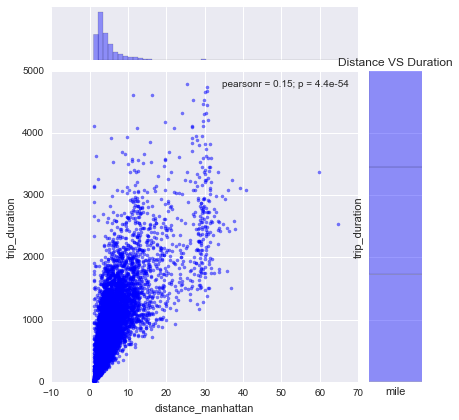

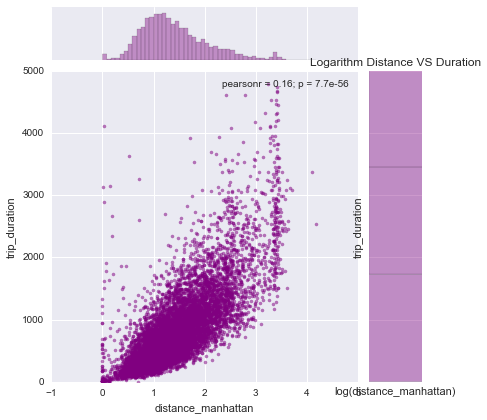

In [31]:
# distance VS duration 
sns.jointplot((df_train_["distance_manhattan"][:10000]+1),(df_train_["trip_duration"][:10000]+1),s=10,alpha=0.5,color='blue')
plt.xlabel('mile')
plt.ylabel('trip_duration')
plt.xlim(0,30)
plt.ylim(0,5000)
plt.title('Distance VS Duration')
plt.show()

# log distance VS duration 
sns.jointplot(np.log(df_train_["distance_manhattan"][:10000]+1),(df_train_["trip_duration"][:10000]+1),s=10,alpha=0.5,color='purple')
plt.xlim(0,30)
plt.ylim(0,5000)
plt.title('Logarithm Distance VS Duration')
plt.xlabel('log(distance_manhattan)')
plt.ylabel('trip_duration')
plt.show()

#### There are positive relations within `distance and duration`  in the cases : 
    - (logarithm) haversine distance VS. duration 
    - (logarithm) manhattan distance VS. duration 
   which fit common sense: trip takes longer when distance longer 
   
#### ** log(distance) VS duration  seems has `better co-relation`, will add log(distance) as new feature

### 4-1') haversine VS manhattan

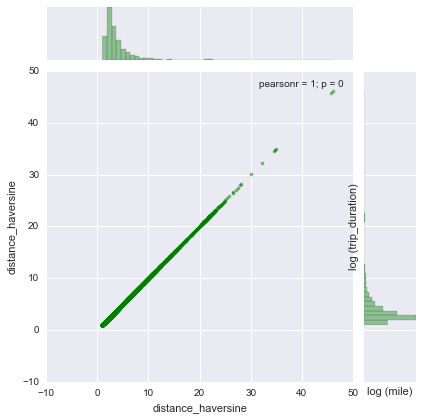

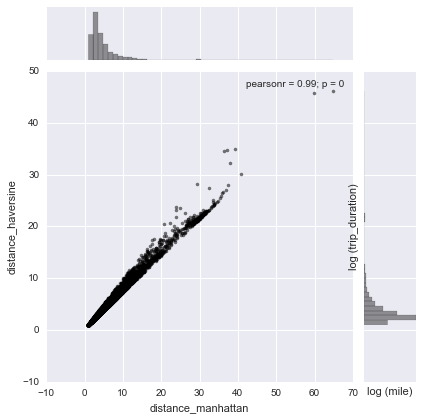

In [32]:
# ref 
# https://www.kaggle.com/hanriver0618/nyc-taxi-data-exploration-visualization

# haversine distance VS duration 
# or u can plot all data points, still a linear relation 
#sns.jointplot(np.log10(df_train_["distance_haversine"][:10000]+1),np.log10(df_train_["distance_haversine"][:10000]+1),s=10,alpha=0.5,color='green')
sns.jointplot((df_train_["distance_haversine"][:10000]+1),(df_train_["distance_haversine"][:10000]+1),s=10,alpha=0.5,color='green')
plt.xlabel('log (mile)')
plt.ylabel('log (trip_duration)')
plt.show()

# manhattan distance VS duration 
# or u can plot all data points, still a linear relation
sns.jointplot((df_train_["distance_manhattan"][:10000]+1),(df_train_["distance_haversine"][:10000]+1),s=10,alpha=0.5,color='black')
plt.xlabel('log (mile)')
plt.ylabel('log (trip_duration)')
plt.show()

#### Haversine and manhattan (distance) are too `linear co-related`,
maybe only `input one of them` when modeling, avoiding possbile 
co-linear effect by too much relation features in same model

### 4-2) Speed VS Times

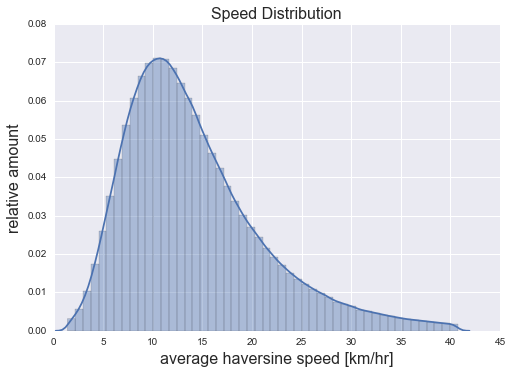

In [33]:
# remove potential outliers for better visualization
df_avg_speed = df_train_[(df_train_['avg_speed_h'] < df_train_['avg_speed_h'].quantile(0.99))&
         (df_train_['avg_speed_h'] > df_train_['avg_speed_h'].quantile(0.01))]

sns.distplot(df_avg_speed.avg_speed_h)
plt.xlabel('average haversine speed [km/hr]',fontsize=16)
plt.ylabel('relative amount',fontsize=16)
plt.title('Speed Distribution',fontsize=16)
plt.show()

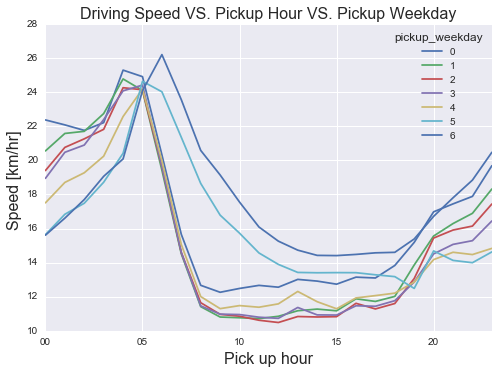

In [34]:
# Speed in different situations 
plt.figure(figsize=(20,12))
pd.pivot_table(df_train_, index='pickup_hour',columns='pickup_weekday' ,aggfunc=np.mean)['avg_speed_h'].plot()
plt.xlabel('Pick up hour',fontsize=16)
plt.ylabel('Speed [km/hr] ',fontsize=16)
plt.title('Driving Speed VS. Pickup Hour VS. Pickup Weekday',fontsize=16)



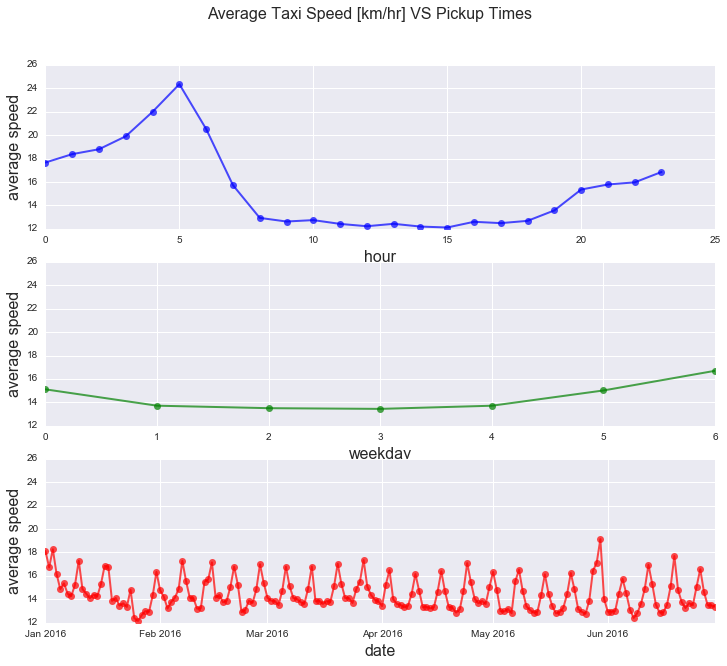

In [35]:
# haversine speed visualization 

fig, ax = plt.subplots(nrows=3, sharey=True)
fig.set_size_inches(12, 10)
ax[0].plot(df_train_.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(df_train_.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(df_train_.groupby('pickup_date').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour',fontsize=16)
ax[1].set_xlabel('weekday',fontsize=16)
ax[2].set_xlabel('date',fontsize=16)
ax[0].set_ylabel('average speed',fontsize=16)
ax[1].set_ylabel('average speed',fontsize=16)
ax[2].set_ylabel('average speed',fontsize=16)
fig.suptitle('Average Taxi Speed [km/hr] VS Pickup Times',fontsize=16)
plt.show()

#### `Speed` relate to  `Pickup Hour` strongly
    - 1. When in `non-rush hours`, taxi can drive faster
    - 2. Speed peak is within 5 am in weekday ; within 7 am in weekend
    - 3. Speed fluctuate periodically by days 
    - 4. Average speed of around 15 km/h looks reasonable for NYC. 


### 4-3) Driving Direction

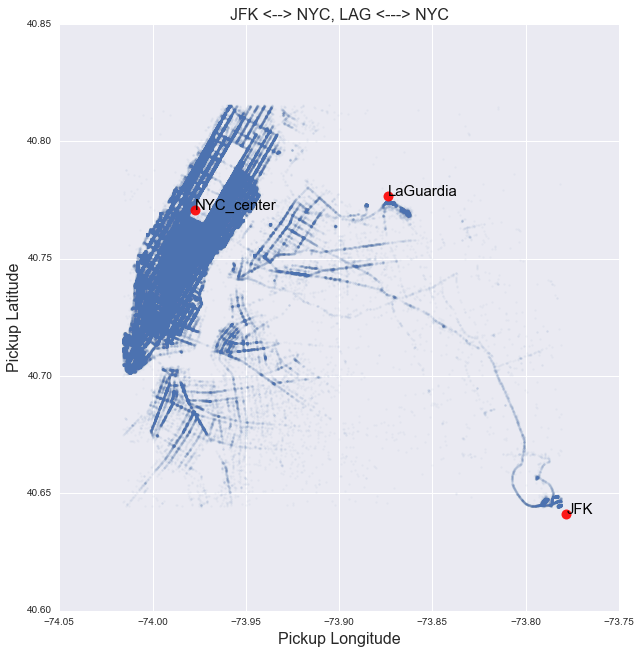

In [36]:
# pickup 
sns.lmplot(x="pickup_longitude", y="pickup_latitude", fit_reg=False, 
           size=9, scatter_kws={'alpha':0.05,'s':5}, data=df_train_[(
                 df_train_.pickup_longitude>df_train_.pickup_longitude.quantile(0.005))
               &(df_train_.pickup_longitude<df_train_.pickup_longitude.quantile(0.995))
               &(df_train_.pickup_latitude>df_train_.pickup_latitude.quantile(0.005))                           
               &(df_train_.pickup_latitude<df_train_.pickup_latitude.quantile(0.995))])

JFK_location=[-73.778203,40.641165]
LaGuardia_location = [-73.873923,40.776935]
NYC_center = [-73.977282,40.770940]

### transform locations to dataframe 
locations=pd.DataFrame({'JFK':JFK_location,
             'LaGuardia':LaGuardia_location,
             'NYC':NYC_center}).T
locations.columns=['lon','lat']
###

plt.plot(JFK_location[0],JFK_location[1],'o', color = 'r',alpha=0.9,markersize=10)
plt.plot(LaGuardia_location[0],LaGuardia_location[1],'o', color = 'r',alpha=0.9,markersize=10)
plt.plot(NYC_center[0],NYC_center[1],'o', color = 'r',alpha=0.9,markersize=10)
plt.annotate('NYC_center', (NYC_center[0], NYC_center[1]), color = 'black', fontsize = 15)
plt.annotate('LaGuardia', (LaGuardia_location[0], LaGuardia_location[1]), color = 'black', fontsize = 15)
plt.annotate('JFK', (JFK_location[0], JFK_location[1]), color = 'black', fontsize = 15)


plt.xlabel('Pickup Longitude',fontsize=16);
plt.ylabel('Pickup Latitude',fontsize=16);
plt.title('JFK <--> NYC, LAG <---> NYC',fontsize=16)
plt.show()

In [37]:
# GET angles between main aiport and NYC downtown
JFK_NYC= get_direction(JFK_location[0],
                       JFK_location[1],
                       NYC_center[0],
                       NYC_center[1])

LAG_NYC= get_direction(LaGuardia_location[0],
                       LaGuardia_location[1],
                       NYC_center[0],
                       NYC_center[1])

print ('JFK - NYC_center angle = ',JFK_NYC )
print ('LAG - NYC_center angle = ',LAG_NYC )

JFK - NYC_center angle =  169.801849301
LAG - NYC_center angle =  -179.082799119


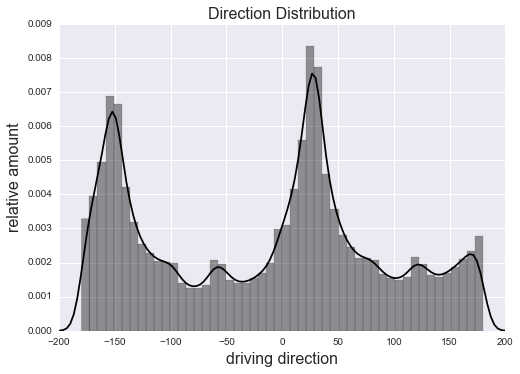

In [38]:
sns.distplot(df_train_.direction,color='black')
plt.xlabel('driving direction',fontsize=16)
plt.ylabel('relative amount',fontsize=16)
plt.title('Direction Distribution',fontsize=16)
plt.show()

#### There are 2 peaks  around `30 and -150 degrees` in direction distribution
 - Maybe 
     - The 30 ones represent orders from JFK -> Manhattan ; 
     - The 150 ones represent orders form LAF -> Manhattan ;
 - JFK - NYC_center angle =  169.801849301
 - LAG - NYC_center angle =  -179.082799119

### -4.3) Clustering 

In [39]:
from sklearn.cluster import MiniBatchKMeans
# get lon & lat clustering for following avg location speed calculation
def get_clustering(df):
    coords = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    df_test[['pickup_latitude', 'pickup_longitude']].values,
                    df_test[['dropoff_latitude', 'dropoff_longitude']].values))
    df_ = df.copy()
    sample_ind = np.random.permutation(len(coords))[:500000]
    kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000).fit(coords[sample_ind])
    df_.loc[:, 'pickup_cluster'] = kmeans.predict(df_[['pickup_latitude', 'pickup_longitude']])
    df_.loc[:, 'dropoff_cluster'] = kmeans.predict(df_[['dropoff_latitude', 'dropoff_longitude']])
    # a little bit modify clustering function here 
    return df_,kmeans

In [40]:
df_train_,kmeans = get_clustering(df_train_)

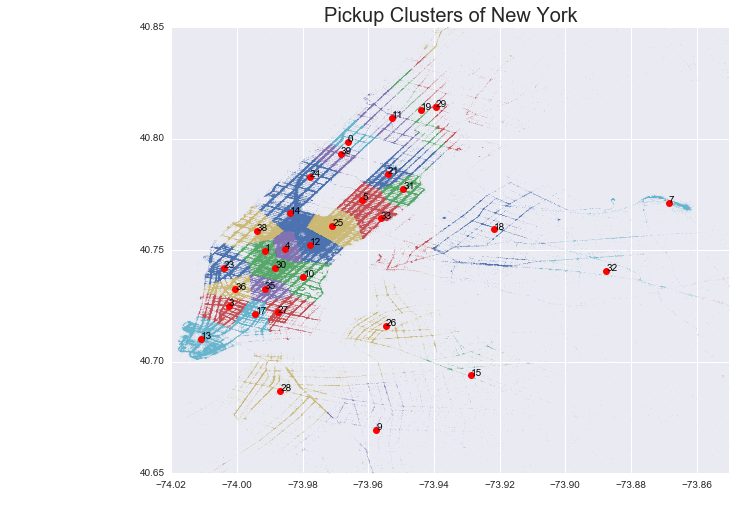

In [41]:
# clustering pickup lon & lat
# https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation
# https://matplotlib.org/users/annotations.html

fig,ax = plt.subplots(figsize = (10,8))
for label in df_train_.pickup_cluster.unique():
    ax.plot(df_train_.pickup_longitude[df_train_.pickup_cluster == label],df_train_.pickup_latitude[df_train_.pickup_cluster == label],'.', alpha = 0.9, markersize = 0.5)
    ax.plot(kmeans.cluster_centers_[label,1],kmeans.cluster_centers_[label,0],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,1],kmeans.cluster_centers_[label,0]), color = 'black', fontsize = 10)

plt.title('Pickup Clusters of New York',fontsize=20)
plt.xlim(-74.02,-73.85)
plt.ylim(40.65,40.85)
plt.show()

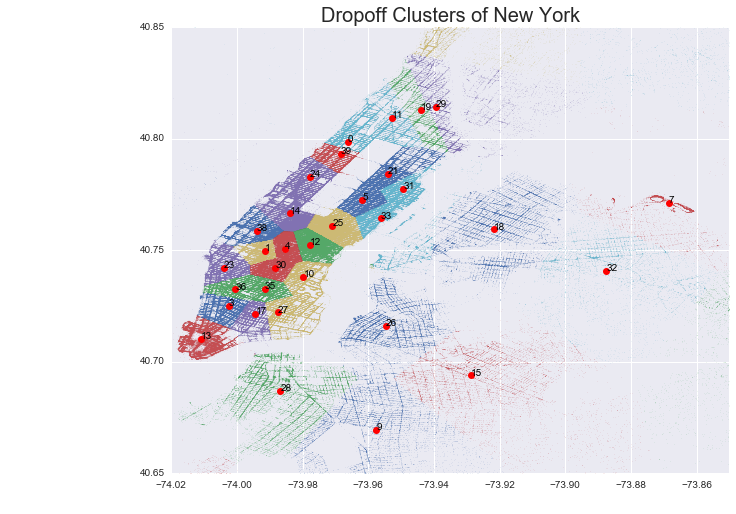

In [42]:
# clustering pickup lon & lat
# https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation
# https://matplotlib.org/users/annotations.html

fig,ax = plt.subplots(figsize = (10,8))
for label in df_train_.dropoff_cluster.unique():
    ax.plot(df_train_.dropoff_longitude[df_train_.dropoff_cluster == label],df_train_.dropoff_latitude[df_train_.dropoff_cluster == label],'.', alpha = 0.9, markersize = 0.5)
    ax.plot(kmeans.cluster_centers_[label,1],kmeans.cluster_centers_[label,0],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,1],kmeans.cluster_centers_[label,0]), color = 'black', fontsize = 10)

plt.title('Dropoff Clusters of New York',fontsize=20)
plt.xlim(-74.02,-73.85)
plt.ylim(40.65,40.85)
plt.show()

### 4.4) Avg speed, orders on clustering 

In [43]:
df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,trip_duration_cal,pickup_week_,pickup_weekday_,distance_haversine,distance_manhattan,direction,avg_speed_h,avg_speed_m,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,00:07:35,0,Monday,1.498521,1.735433,99.970196,11.856428,13.730901,14,5


In [54]:
#df_train_.groupby(['pickup_cluster','dropoff_cluster']).mean()['avg_speed_h'].reset_index()

In [51]:
# avg speed on cluster 

def avg_cluser_speed(df):
    df_ = df.copy()
    # avg speed on cluster 
    avg_cluser_h = df_.groupby(['pickup_cluster','dropoff_cluster']).mean()['avg_speed_h'].reset_index()
    avg_cluser_h.columns = ['pickup_cluster','dropoff_cluster','avg_speed_cluster_h']
    avg_cluser_m = df_.groupby(['pickup_cluster','dropoff_cluster']).mean()['avg_speed_m'].reset_index()
    avg_cluser_m.columns = ['pickup_cluster','dropoff_cluster','avg_speed_cluster_m']
    # merge dataframe
    df_ = pd.merge(df_,avg_cluser_h, how = 'left', on = ['pickup_cluster','dropoff_cluster'])
    df_ = pd.merge(df_,avg_cluser_m, how = 'left', on = ['pickup_cluster','dropoff_cluster'])
    return df_


In [52]:

df_train_  = avg_cluser_speed(df_train_)

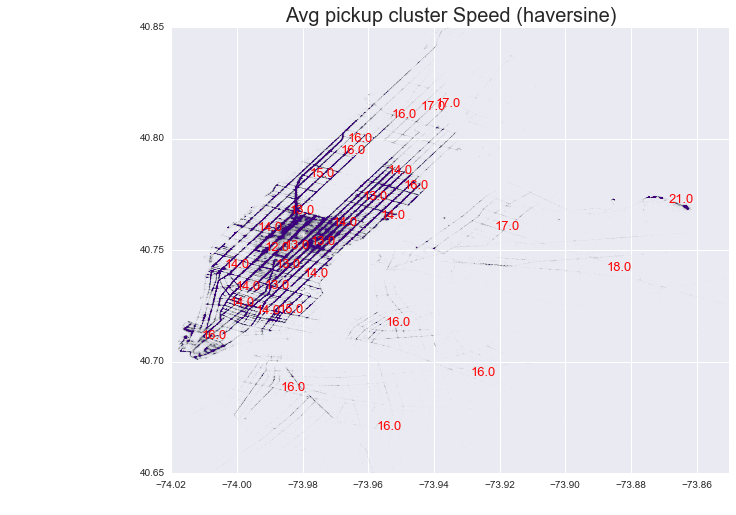

pickup_cluster,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
avg_speed_cluster_h,16.157686,12.476266,23.351376,13.858003,13.25048,13.307185,30.513296,21.389366,28.079077,16.296234,...,12.545773,15.556565,17.974274,14.30781,19.570805,12.876944,13.87878,16.161457,14.058084,15.819285


In [53]:
# plot avg speed as heat map 


# https://stackoverflow.com/questions/12857925/how-to-convert-data-values-into-color-information-for-matplotlib
hot = plt.get_cmap('Purples')

fig,ax = plt.subplots(figsize = (10,8))
for label in df_train_.dropoff_cluster.unique():
    avg_cluster_speed= round(df_train_[df_train_.pickup_cluster ==label]['avg_speed_cluster_h'].mean())

    ax.plot(df_train_.pickup_longitude[df_train_.pickup_cluster == label],df_train_.pickup_latitude[df_train_.pickup_cluster == label],'.'\
    ,c=hot(avg_cluster_speed/10), alpha = 0.2, markersize = .3)
    if avg_cluster_speed == 'nan':
        pass
    else:
        ax.annotate(avg_cluster_speed, (kmeans.cluster_centers_[label,1],kmeans.cluster_centers_[label,0]), color = 'red', fontsize = 13)

plt.title('Avg pickup cluster Speed (haversine)',fontsize=20)
plt.xlim(-74.02,-73.85)
plt.ylim(40.65,40.85)
plt.show()


pd.DataFrame(df_train_.groupby('pickup_cluster').mean()['avg_speed_cluster_h']).transpose()             
    

#### Out-of-downtown, and north area seems has `higher` avg cluster speed` (16-21 km/hr)`, while middle and downtown area `ubder 15 (km/hr)`  mostly